In [43]:
import numpy as np
import pandas as pd  # Import pandas for DataFrame operations
from pyDOE import lhs  # For Latin Hypercube Sampling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

# Material parameter ranges (based on the paper)
E_range = [60000000000, 210000000000]
sigma_y_range = [90000000, 1000000000]
c_range = [1000000, 250000000000]
gamma_range = [0, 10000]
b_range = [1, 40]
Q_range = [1000000, 150000000]

# Function to generate material constants using Latin Hypercube Sampling
def generate_material_constants_lhs(num_samples):
    lhs_samples = lhs(10, samples=num_samples)
    E = lhs_samples[:, 0] * (E_range[1] - E_range[0]) + E_range[0]
    sigma_y = lhs_samples[:, 1] * (sigma_y_range[1] - sigma_y_range[0]) + sigma_y_range[0]
    c = lhs_samples[:, 2:5] * (c_range[1] - c_range[0]) + c_range[0]  # c1, c2, c3
    gamma = lhs_samples[:, 5:8] * (gamma_range[1] - gamma_range[0]) + gamma_range[0]  # gamma1, gamma2, gamma3
    b = lhs_samples[:, 8] * (b_range[1] - b_range[0]) + b_range[0]
    Q = lhs_samples[:, 9] * (Q_range[1] - Q_range[0]) + Q_range[0]
    return np.column_stack((E, sigma_y, c, gamma, b, Q))

# Function to generate strain increments
#def generate_strain_increments(num_samples, lb=0.0001, ub=0.0002):
#    return np.random.uniform(lb, ub, num_samples)
def generate_strain_increments(num_samples, lb=0.01, ub=0.02):
    # Create an empty array to store strain increments
    strain_increments = np.zeros(num_samples)
    
    # First range: n = 1 to 300
    strain_increments[:300] = np.random.uniform(lb, ub, 300)
    
    # Second range: n = 301 to 900
    strain_increments[300:900] = -np.random.uniform(lb, ub, 600)
    
    # Third range: n = 901 to 1500
    strain_increments[900:1500] = np.random.uniformreturn mapping(lb, ub, 600)
    print(strain_increments)
    
    return strain_increments

# Modified return mapping algorithm to handle multiple back stress components (M = 3)
def return_mapping_algorithm_multi(trial_stress, sigma_y, c, gamma, b, Q, strain_increment, tolerance=1e-5, max_iter=50):
    plastic_strain_increment = 0.0
    back_stress = np.zeros(3)  # M = 3, so we have three back stress components
    isotropic_hardening = 0.0
    phi_trial = (np.abs(trial_stress - np.sum(back_stress))) - (sigma_y + isotropic_hardening)
    
    if phi_trial <= 0:
        return 0.0
    
    for _ in range(max_iter):
        print('plastic')
        delta_gamma = plastic_strain_increment
        # Update back stress components (kinematic hardening)
        for i in range(3):
            back_stress[i] += (2/3) * c[i] * delta_gamma - gamma[i] * back_stress[i] * np.abs(delta_gamma)
        
        # Update isotropic hardening
        isotropic_hardening += b * (Q - isotropic_hardening) * np.abs(delta_gamma)
        
        # Recalculate the yield function with the updated values
        phi = np.abs(trial_stress - np.sum(back_stress)) - (sigma_y + isotropic_hardening)
        
        if np.abs(phi) < tolerance:
            break
        
        # Derivative of phi with respect to gamma for the Newton-Raphson update
        dphi_dgamma = np.sum((2/3) * c - gamma * back_stress)  # Sum of derivatives for each back stress component
        
        # Update the plastic strain increment using the Newton-Raphson method
        plastic_strain_increment -= phi / dphi_dgamma
    
    return plastic_strain_increment

# Generate the dataset
def generate_dataset(num_material_samples=500, num_strain_samples=1500):
    material_constants = generate_material_constants_lhs(num_material_samples)
    strain_increments = generate_strain_increments(num_strain_samples)
    plt.plot(strain_increments)
    
    # Create Cartesian product: for each material constant set, apply all strain increments
    repeated_material_constants = np.repeat(material_constants, len(strain_increments) // num_material_samples, axis=0)
    repeated_strain_increments = np.tile(strain_increments, num_material_samples)
    dataset = []
    
    for i in range(len(repeated_material_constants)):
        E, sigma_y, c, gamma, b, Q = repeated_material_constants[i, 0], repeated_material_constants[i, 1], \
                                     repeated_material_constants[i, 2:5], repeated_material_constants[i, 5:8], \
                                     repeated_material_constants[i, 8], repeated_material_constants[i, 9]
        strain_inc = repeated_strain_increments[i]
        trial_stress = E * strain_inc
        trial_phi = np.abs(trial_stress) - sigma_y  # Simplified trial_phi calculation
        delta_ep = return_mapping_algorithm_multi(trial_stress, sigma_y, c, gamma, b, Q, strain_inc)
        dataset.append(np.hstack([repeated_material_constants[i], trial_phi, delta_ep]))
    
    dataset = np.array(dataset)
    return dataset

# Convert dataset to pandas DataFrame and save it to a CSV file
def save_dataset_to_csv(dataset, filename="generated_dataset3.csv"):
    columns = ['E', 'sigma_y', 'c1', 'c2', 'c3', 'gamma1', 'gamma2', 'gamma3', 'b', 'Q', 'trial_phi', 'plastic_strain']
    df = pd.DataFrame(dataset, columns=columns)
    df.to_csv(filename, index=False)
    print(f"Dataset saved to {filename}")



SyntaxError: invalid syntax (364604973.py, line 45)

In [44]:
# Normalize the dataset
def normalize_dataset(data):
    scaler = MinMaxScaler()
    return scaler.fit_transform(data), scaler

# Split dataset into training and testing sets
def split_dataset(X, y):
    return train_test_split(X, y, test_size=0.2, random_state=42)

# Build the neural network
def build_model(input_dim):
    model = Sequential([
        Dense(10, activation='sigmoid', input_shape=(input_dim,)),
        Dense(1, activation='linear')
    ])
    custom_adam = tf.keras.optimizers.Adam(learning_rate=.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
    model.compile(optimizer=custom_adam, loss='mean_squared_error', metrics=['mae'])
    return model

# Plot training and validation loss
def plot_loss(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)LHS
    plt.show()
    plt.savefig('loss_curve')  # Save the plot as an image file
    plt.close()  # Close the plot to avoid displaying it in the notebook
    print(f"Plot saved as {'loss_curve'}")

# Plot original vs predicted values
def plot_predicted_vs_actual(y_test, y_pred):
    plt.figure(figsize=(8, 6))
    plt.plot(y_test, label='Original Values', color='blue')
    plt.plot(y_pred, label='Predicted Values', color='red', linestyle='--')
    plt.xlabel('Sample index')
    plt.ylabel('Plastic Strain')
    plt.title('Predicted vs. Original Plastic Strain')
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.savefig('predicted_vs_actual')  # Save the plot as an image file
    plt.close()  # Close the plot to avoid displaying it in the notebookLHSLHS
    print(f"Plot saved as {'predicted_vs_actual'}")


SyntaxError: invalid syntax (188887777.py, line 29)

[0.00133889 0.00178583 0.00103189 ... 0.00135965 0.00140231 0.00155141]
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic


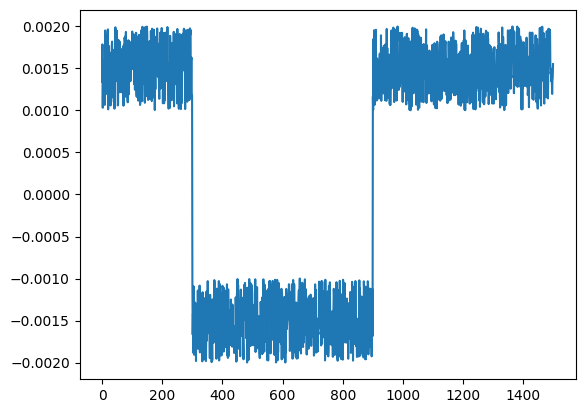

In [45]:
# Generate dataset
dataset = generate_dataset()

In [46]:
columns = ['E', 'sigma_y', 'c1', 'c2', 'c3', 'gamma1', 'gamma2', 'gamma3', 'b', 'Q', 'trial_phi', 'plastic_strain']
df = pd.DataFrame(dataset, columns=columns)

<Axes: >

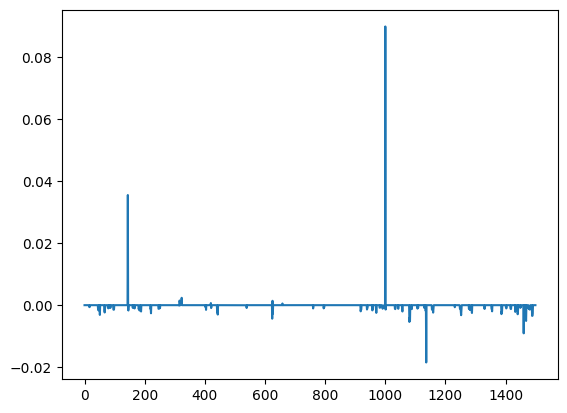

In [47]:
df['plastic_strain'].plot()

In [27]:
dataset[700]

array([ 2.06723135e+11,  9.78157700e+08,  1.76208952e+11,  9.89410261e+10,
        1.42296706e+11,  4.20876704e+03,  5.78256293e+03,  9.15461286e+03,
        1.76538374e+01,  1.18643583e+07, -9.46358029e+08,  0.00000000e+00])

In [29]:
dataset[200]

array([ 1.19718529e+11,  2.45630610e+08,  6.46072356e+10,  3.09809356e+10,
        2.36544538e+11,  3.98276848e+03,  3.72365561e+02,  8.96737401e+03,
        3.79850790e+01,  1.45671175e+08, -2.26803704e+08,  0.00000000e+00])

In [57]:
strain_increments

NameError: name 'strain_increments' is not defined

[0.00010319 0.00011056 0.00018746 ... 0.00012792 0.00019671 0.00019605]


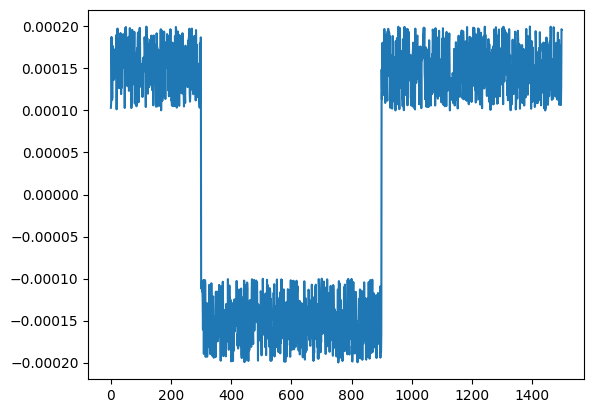

In [77]:
dataset = generate_dataset()

In [ ]:
# Generate dataset
dataset = generate_dataset()

# Separate features and targetsy_test_normalized = normalize_data(y_test_example)
#y_pred_normalized = normalize_data(y_pred_example)
X = dataset[:, :-1]  # Features (material constants, trial_phi)
y = dataset[:, -1]   # Targets (|delta_ep|)

# Normalize the dataset
X_normalized, scaler_X = normalize_dataset(X)
y_normalized, scaler_y = normalize_dataset(y.reshape(-1, 1))
#y_test_normalized = normalize_data(y_test_example)
#y_pred_normalized = normalize_data(y_pred_example)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = split_dataset(X_normalized, y_normalized)

# Build the neural network model
model = build_model(X_train.shape[1])

# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',    # Monitor the validation loss
    patience=20,           # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

# Train the model with early stopping
history = model.fit(
    X_train, 
    y_train, 
    epochs=1000,              # Set a large number of epochs
    batch_size=1000, 
    validation_split=0.2, 
    callbacks=[early_stopping]  # Include the early stopping callback
)

# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test MAE: {test_mae}")

# Make predictions
y_pred = model.predict(X_test)

# Denormalize predictions and actual values
y_pred_denormalized = scaler_y.inverse_transform(y_pred)
y_test_denormalized = scaler_y.inverse_transform(y_test)

# Plot training and validation lossback_stress
plot_loss(history)

# Plot predicted vs original values
plot_predicted_vs_actual(y_test, y_pred)


[0.00012434 0.00010712 0.00014077 ... 0.00015984 0.00012018 0.00012598]
Epoch 1/1000


/home/uashfaq/anaconda3/envs/elasticity/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step - loss: 0.0309 - mae: 0.1584 - val_loss: 0.0267 - val_mae: 0.1461
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0278 - mae: 0.1484 - val_loss: 0.0239 - val_mae: 0.1361
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0250 - mae: 0.1385 - val_loss: 0.0213 - val_mae: 0.1263
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0223 - mae: 0.1288 - val_loss: 0.0189 - val_mae: 0.1170
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0199 - mae: 0.1197 - val_loss: 0.0167 - val_mae: 0.1083
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0177 - mae: 0.1112 - val_loss: 0.0147 - val_mae: 0.1001
Epoch 7/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0157 - mae: 0.1034 - val_loss: 0.0130 - val_mae: 0.0925
Epoch 8/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0140 - mae: 0.0964 - val_loss: 0.0115 - val_mae: 0.0860
Epoch 9/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0124 - mae: 0.0

In [59]:
y_test[1:20]

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [60]:
y_pred[1:20]

array([[-0.00183608],
       [ 0.00221889],
       [-0.01321658],
       [-0.00681248],
       [ 0.00353464],
       [ 0.01452277],
       [-0.00109687],
       [ 0.01321281],
       [ 0.0099574 ],
       [-0.00224266],
       [ 0.00941364],
       [ 0.00360443],
       [ 0.00943025],
       [-0.00208806],
       [-0.00090586],
       [-0.00323547],
       [-0.00842281],
       [-0.0043808 ],
       [ 0.00248189]], dtype=float32)

In [61]:
np.unique(y_test)

array([0.])